# 02. Convert MNE sample data to BIDS format

In this example we will use MNE-BIDS to organize the MNE sample data according
to the BIDS standard.
In a second step we will read the organized dataset using MNE-BIDS. 

The notebook is based on the MNE-BIDS tutorial available at:
https://mne.tools/mne-bids/v0.15/auto_examples/convert_mne_sample.html#

In [1]:
# Authors: Mainak Jas <mainak.jas@telecom-paristech.fr>
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Teon Brooks <teon.brooks@gmail.com>
#          Stefan Appelhoff <stefan.appelhoff@mailbox.org>
#          Richard Höchenberger <richard.hoechenberger@gmail.com>
#
# License: BSD-3-Clause

First we import some basic Python libraries, followed by MNE-Python and its
sample data, and then finally the MNE-BIDS functions we need for this example



In [2]:
import json
import os.path as op
from pprint import pprint
import shutil

import mne
from mne.datasets import sample

from mne_bids import (
    write_raw_bids,
    read_raw_bids,
    write_meg_calibration,
    write_meg_crosstalk,
    BIDSPath,
    print_dir_tree,
    make_dataset_description,
)
from mne_bids.stats import count_events

Now we can read the MNE sample data. We define an `event_id` based on our
knowledge of the data, to give meaning to events in the data.

With `raw_fname` and `events`, we determine where to get the sample data
from. `output_path` determines where we will write the BIDS conversion to.



In [3]:
data_path = sample.data_path()
event_id = {
    "Auditory/Left": 1,
    "Auditory/Right": 2,
    "Visual/Left": 3,
    "Visual/Right": 4,
    "Smiley": 5,
    "Button": 32,
}

raw_fname = op.join(data_path, "MEG", "sample", "sample_audvis_raw.fif")
er_fname = op.join(data_path, "MEG", "sample", "ernoise_raw.fif")  # empty room
events_fname = op.join(data_path, "MEG", "sample", "sample_audvis_raw-eve.fif")
output_path = op.join(data_path, "..", "MNE-sample-data-bids")

To ensure the output path doesn't contain any leftover files from previous
tests and example runs, we simply delete it.

<div class="alert alert-danger"><h4>Warning</h4><p>Do not delete directories that may contain important data!</p></div>




In [4]:
if op.exists(output_path):
    shutil.rmtree(output_path)

<div class="alert alert-info"><h4>Note</h4><p>``mne-bids`` will try to infer as much information from the data as
  possible to then save this data in BIDS-specific "sidecar" files. For
  example the manufacturer information, which is inferred from the data file
  extension. However, sometimes inferring is ambiguous (e.g., if your file
  format is non-standard for the manufacturer). In these cases, MNE-BIDS does
  *not* guess and you will have to update your BIDS fields manually.</p></div>

Based on our path definitions above, we read the raw data file, define
a new BIDS name for it, and then run the automatic BIDS conversion for both
the experimental data and its associated empty-room recording.



In [5]:
raw = mne.io.read_raw(raw_fname)
raw_er = mne.io.read_raw(er_fname)

# specify power line frequency as required by BIDS
raw.info["line_freq"] = 60
raw_er.info["line_freq"] = 60

task = "audiovisual"
bids_path = BIDSPath(
    subject="01", task=task, run="01", datatype="meg", root=output_path
)
write_raw_bids(
    raw=raw,
    bids_path=bids_path,
    events=events_fname,
    event_id=event_id,
    empty_room=raw_er,
    overwrite=True,
)

Opening raw data file /home/cognestic/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Opening raw data file /home/cognestic/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.
Opening raw data file /home/cognestic/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Opening raw data file /home/cognestic/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif

BIDSPath(
root: /home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids
datatype: meg
basename: sub-01_task-audiovisual_run-01_meg.fif)

Let's pause and check that the information that we've written out to the
sidecar files that describe our data is correct.



In [6]:
# Get the sidecar ``.json`` file
sidecar_json_bids_path = bids_path.copy().update(suffix="meg", extension=".json")
sidecar_json_content = sidecar_json_bids_path.fpath.read_text(encoding="utf-8-sig")
print(sidecar_json_content)

{
    "TaskName": "audiovisual",
    "Manufacturer": "Elekta",
    "PowerLineFrequency": 60.0,
    "SamplingFrequency": 600.614990234375,
    "SoftwareFilters": {
        "SpatialCompensation": {
            "GradientOrder": 0
        }
    },
    "RecordingDuration": 277.7136813300495,
    "RecordingType": "continuous",
    "DewarPosition": "n/a",
    "DigitizedLandmarks": true,
    "DigitizedHeadPoints": true,
    "MEGChannelCount": 306,
    "MEGREFChannelCount": 0,
    "ContinuousHeadLocalization": false,
    "HeadCoilFrequency": [],
    "AssociatedEmptyRoom": "/sub-emptyroom/ses-20021206/meg/sub-emptyroom_ses-20021206_task-noise_meg.fif",
    "EEGChannelCount": 60,
    "EOGChannelCount": 1,
    "ECGChannelCount": 0,
    "EMGChannelCount": 0,
    "MiscChannelCount": 0,
    "TriggerChannelCount": 9
}



The sample MEG dataset comes with fine-calibration and crosstalk files that
are required when processing Elekta/Neuromag/MEGIN data using MaxFilter®.
Let's store these data in appropriate places, too.



In [7]:
cal_fname = op.join(data_path, "SSS", "sss_cal_mgh.dat")
ct_fname = op.join(data_path, "SSS", "ct_sparse_mgh.fif")

write_meg_calibration(cal_fname, bids_path)
write_meg_crosstalk(ct_fname, bids_path)

Writing fine-calibration file to /home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/meg/sub-01_acq-calibration_meg.dat
Writing crosstalk file to /home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/meg/sub-01_acq-crosstalk_meg.fif


Now let's see the structure of the BIDS folder we created.



In [9]:
print_dir_tree(output_path)

|MNE-sample-data-bids/
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- sub-01/
|------ sub-01_scans.tsv
|------ meg/
|--------- sub-01_acq-calibration_meg.dat
|--------- sub-01_acq-crosstalk_meg.fif
|--------- sub-01_coordsystem.json
|--------- sub-01_task-audiovisual_run-01_channels.tsv
|--------- sub-01_task-audiovisual_run-01_events.json
|--------- sub-01_task-audiovisual_run-01_events.tsv
|--------- sub-01_task-audiovisual_run-01_meg.fif
|--------- sub-01_task-audiovisual_run-01_meg.json
|--- sub-emptyroom/
|------ ses-20021206/
|--------- sub-emptyroom_ses-20021206_scans.tsv
|--------- meg/
|------------ sub-emptyroom_ses-20021206_task-noise_channels.tsv
|------------ sub-emptyroom_ses-20021206_task-noise_meg.fif
|------------ sub-emptyroom_ses-20021206_task-noise_meg.json


Now let's get an overview of the events on the whole dataset



In [10]:
counts = count_events(output_path)
counts

audiovisual                                           \
trial_type  Auditory/Left Auditory/Right Button Smiley Visual/Left   
subject run                                                          
01      01             72             73     16     15          73   

                          
trial_type  Visual/Right  
subject run               
01      01            71

A big advantage of having data organized according to BIDS is that software
packages can automate your workflow. For example, reading the data back
into MNE-Python can easily be done using :func:`read_raw_bids`.



In [11]:
raw = read_raw_bids(bids_path=bids_path)

Opening raw data file /home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/meg/sub-01_task-audiovisual_run-01_meg.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading events from /home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/meg/sub-01_task-audiovisual_run-01_events.tsv.
Reading channel info from /home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/meg/sub-01_task-audiovisual_run-01_channels.tsv.


The resulting data is already in a convenient form to create epochs and
evoked data.



Used Annotations descriptions: ['Auditory/Left', 'Auditory/Right', 'Button', 'Smiley', 'Visual/Left', 'Visual/Right']
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated


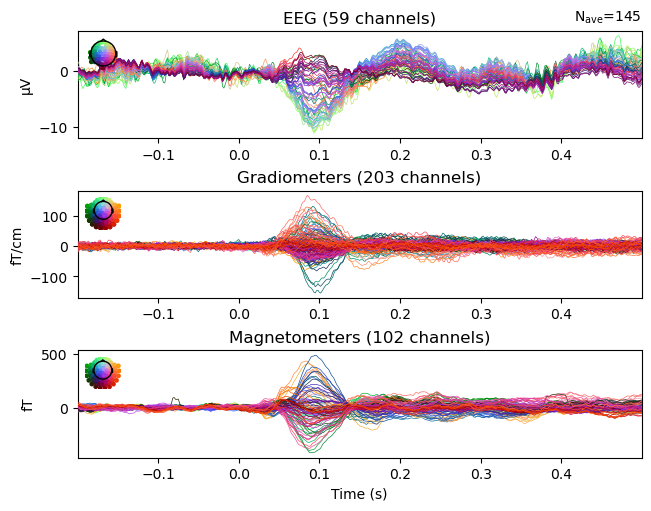

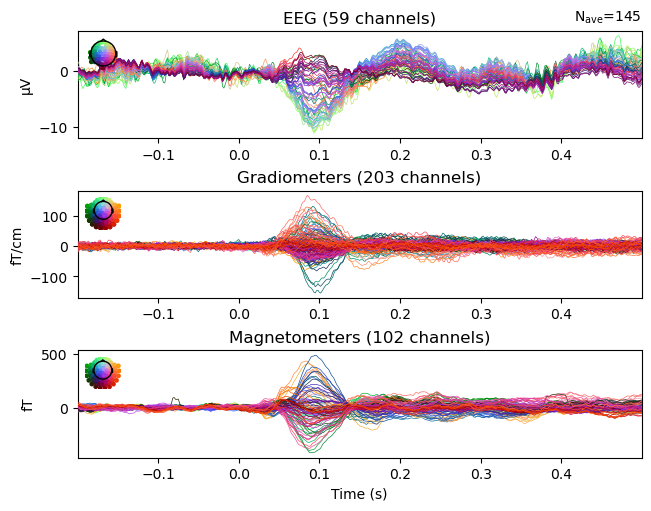

In [12]:
events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, event_id)
epochs["Auditory"].average().plot()

We can easily get the :class:`mne_bids.BIDSPath` of the empty-room recording
that was associated with the experimental data while writing. The empty-room
data can then be loaded with :func:`read_raw_bids`.



In [13]:
er_bids_path = bids_path.find_empty_room(use_sidecar_only=True)
er_data = read_raw_bids(er_bids_path)
er_data

Using "AssociatedEmptyRoom" entry from MEG sidecar file to retrieve empty-room path.
Opening raw data file /home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-emptyroom/ses-20021206/meg/sub-emptyroom_ses-20021206_task-noise_meg.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.
Reading channel info from /home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-emptyroom/ses-20021206/meg/sub-emptyroom_ses-20021206_task-noise_channels.tsv.


Measurement date,"December 06, 2002 15:16:18 GMT"
Experimenter,mne_anonymize
Participant,sub-emptyroom
Digitized points,Not available
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus"
Bad channels,MEG 2443
EOG channels,Not available
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


It is trivial to retrieve the path of the fine-calibration and crosstalk
files, too.



In [14]:
print(bids_path.meg_calibration_fpath)
print(bids_path.meg_crosstalk_fpath)

/home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/meg/sub-01_acq-calibration_meg.dat
/home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/sub-01/meg/sub-01_acq-crosstalk_meg.fif


The README created by :func:`write_raw_bids` also takes care of the citation
for mne-bids. If you are preparing a manuscript, please make sure to also
cite MNE-BIDS there.



In [15]:
readme = op.join(output_path, "README")
with open(readme, "r", encoding="utf-8-sig") as fid:
    text = fid.read()
print(text)

References
----------
Appelhoff, S., Sanderson, M., Brooks, T., Vliet, M., Quentin, R., Holdgraf, C., Chaumon, M., Mikulan, E., Tavabi, K., Höchenberger, R., Welke, D., Brunner, C., Rockhill, A., Larson, E., Gramfort, A. and Jas, M. (2019). MNE-BIDS: Organizing electrophysiological data into the BIDS format and facilitating their analysis. Journal of Open Source Software 4: (1896).https://doi.org/10.21105/joss.01896

Niso, G., Gorgolewski, K. J., Bock, E., Brooks, T. L., Flandin, G., Gramfort, A., Henson, R. N., Jas, M., Litvak, V., Moreau, J., Oostenveld, R., Schoffelen, J., Tadel, F., Wexler, J., Baillet, S. (2018). MEG-BIDS, the brain imaging data structure extended to magnetoencephalography. Scientific Data, 5, 180110.https://doi.org/10.1038/sdata.2018.110




It is also generally a good idea to add a description of your dataset,
see the `BIDS dataset_description.json definition`_ for more information.



In [16]:
how_to_acknowledge = """\
If you reference this dataset in a publication, please acknowledge its \
authors and cite MNE papers: A. Gramfort, M. Luessi, E. Larson, D. Engemann, \
D. Strohmeier, C. Brodbeck, L. Parkkonen, M. Hämäläinen, \
MNE software for processing MEG and EEG data, NeuroImage, Volume 86, \
1 February 2014, Pages 446-460, ISSN 1053-8119 \
and \
A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, \
R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data \
analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, \
ISSN 1662-453X"""

make_dataset_description(
    path=bids_path.root,
    name=task,
    authors=["Alexandre Gramfort", "Matti Hämäläinen"],
    how_to_acknowledge=how_to_acknowledge,
    acknowledgements="""\
Alexandre Gramfort, Mainak Jas, and Stefan Appelhoff prepared and updated the \
data in BIDS format.""",
    data_license="CC0",
    ethics_approvals=[
        "Human Subjects Division at the University of Washington"
    ],  # noqa: E501
    funding=[
        "NIH 5R01EB009048",
        "NIH 1R01EB009048",
        "NIH R01EB006385",
        "NIH 1R01HD40712",
        "NIH 1R01NS44319",
        "NIH 2R01NS37462",
        "NIH P41EB015896",
        "ANR-11-IDEX-0003-02",
        "ERC-StG-263584",
        "ERC-StG-676943",
        "ANR-14-NEUC-0002-01",
    ],
    references_and_links=[
        "https://doi.org/10.1016/j.neuroimage.2014.02.017",
        "https://doi.org/10.3389/fnins.2013.00267",
        "https://mne.tools/stable/overview/datasets_index.html#sample",
    ],
    doi="doi:10.18112/openneuro.ds000248.v1.2.4",
    overwrite=True,
)
desc_json_path = bids_path.root / "dataset_description.json"
with open(desc_json_path, "r", encoding="utf-8-sig") as fid:
    pprint(json.loads(fid.read()))

Writing '/home/cognestic/mne_data/MNE-sample-data/../MNE-sample-data-bids/dataset_description.json'...
{'Acknowledgements': 'Alexandre Gramfort, Mainak Jas, and Stefan Appelhoff '
                     'prepared and updated the data in BIDS format.',
 'Authors': ['Alexandre Gramfort', 'Matti Hämäläinen'],
 'BIDSVersion': '1.7.0',
 'DatasetDOI': 'doi:10.18112/openneuro.ds000248.v1.2.4',
 'DatasetType': 'raw',
 'EthicsApprovals': ['Human Subjects Division at the University of Washington'],
 'Funding': ['NIH 5R01EB009048',
             'NIH 1R01EB009048',
             'NIH R01EB006385',
             'NIH 1R01HD40712',
             'NIH 1R01NS44319',
             'NIH 2R01NS37462',
             'NIH P41EB015896',
             'ANR-11-IDEX-0003-02',
             'ERC-StG-263584',
             'ERC-StG-676943',
             'ANR-14-NEUC-0002-01'],
 'HowToAcknowledge': 'If you reference this dataset in a publication, please '
                     'acknowledge its authors and cite MNE papers: A

This should be very similar to the `ds000248 dataset_description.json`_!

